## CV Assignment 2 | Raccoon Detection | Laurids Radtke

#### Import some useful libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow_hub as hub

#### Dataset & Modelisation Strategy

I chose the "Raccoon Detection" dataset (https://www.kaggle.com/datasets/debasisdotcom/racoon-detection/data) which I found on Kaggle. The dataset contains 200 images of raccoons as well as a CSV file with the bounding box coordinates. However the CSV file only contains the groundtruth for 174 of the 200 images.

For the generation of new bounding boxes I have chosen Mobilenet v2, a pretrained model with around 15 million parameters. Mobilnet was developed for mobile devices and is relatively lightweight, making it perfect for use on my low-spec laptop.

The model is moderately successful in detecting raccoons in images. Sometimes the animal is not detected at all and in some cases mutiple bounding boxes are drawn for a single animal. However all in all the performance is still acceptable. 

#### Prepare file path variables and load groundtruth

In [502]:
dir_path = "data/Racoon_Images/images/"
csv_file_path = "data/train_labels_.csv"
image_names = os.listdir(dir_path)
random_images = random.sample(image_names, 9) #load 9 random images
bounding_box_df = pd.read_csv(csv_file_path)

#### Plot images with groundtruth bounding boxes

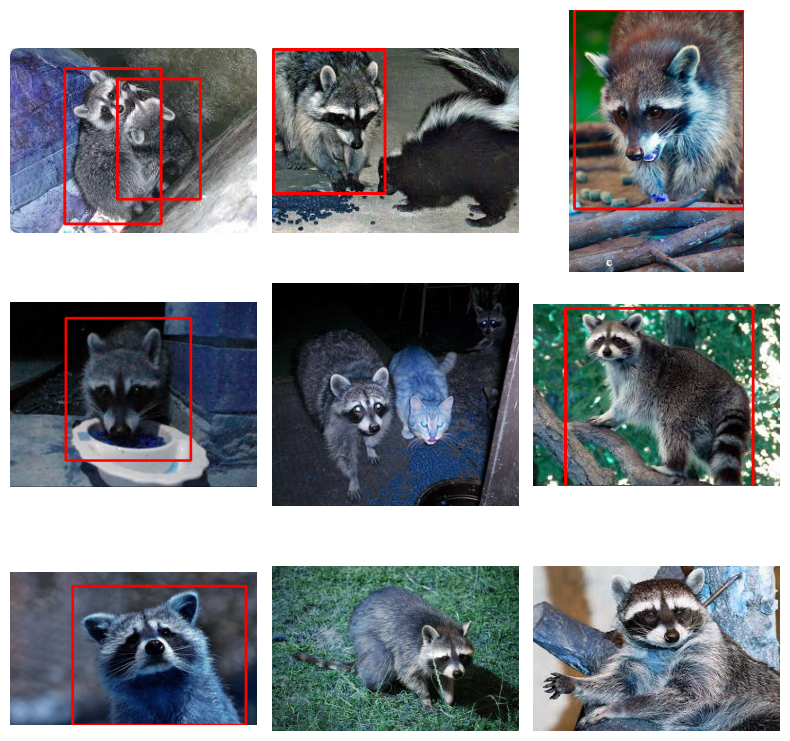

In [663]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, image_file_name in enumerate(random_images):
    image_path = os.path.join(dir_path, image_file_name)
    img = cv2.imread(image_path)

    bbox_info = bounding_box_df[bounding_box_df['filename'] == image_file_name]
    
    image_height, image_width, _ = img.shape
    thickness = max(image_width, image_height) * (1 / 100)

    for _, row in bbox_info.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        cv2.rectangle(img, (xmin, ymax), (xmax, ymin), color=(255, 0, 0), thickness=int(thickness)) #tuple: top left, tuple: bottom right
    
    axes[i // 3, i % 3].imshow(img)
    axes[i // 3, i % 3].axis("off") 
    
plt.tight_layout()
plt.show()

#### Select Model

In [504]:
# ssd mobilenet version 2
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

# Better model but loading and inference takes significantly longer:
#module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

#### Load Model

In [505]:
model = hub.load(module_handle)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


#### Select Model Signature

In [656]:
model.signatures.keys()
pre_trained_detector = model.signatures['default']

#### Define Auxiliary Functions

In [595]:
def display_bboxes(image, bboxes, color, gt_format=False):
    """
    Display bounding boxes on image.
    
    Args:
        image (np array): image as np array on which the bboxes are to be displayed
        bboxes (2d list): array of bbox coordinates
        color (tuple): color of bboxes in RGB format
    """

    thickness = max(image.shape[1], image.shape[2]) * (1 / 100)
    
    for bbox in bboxes:
        """
        print(gt_format)
        print(bboxes)
        print(bbox)
        """
        if not gt_format:
            text = "predicted bbox"
            ymin, xmin, ymax, xmax = bbox
            text_position = (xmin, ymin + 15)
        else:
            text = "ground truth"
            xmin, ymin, xmax, ymax = bbox
            text_position = (xmin, ymax - 5)
        
        cv2.rectangle(image, (xmin, ymax), (xmax, ymin), color=color, thickness=int(thickness)) #tuple: top left, tuple: bottom right
        cv2.putText(image, text, text_position, cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=color, thickness=2)
        
    
def convert_bbox_coordinates(bboxes, im_width, im_height):
    for bbox in bboxes:
        bbox[0] *= im_height
        bbox[1] *= im_width
        bbox[2] *= im_height
        bbox[3] *= im_width

    return bboxes.astype(int).astype(object)
    

def load_image_as_tensor(image_path, target_height, target_width):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Normalize pixel values to the range [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def load_image(image_path):
    return cv2.imread(image_path)

def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
def write_to_csv(data, csv_file, image):
    data = np.insert(data,0,image,axis=1)
    existing_data = pd.read_csv(csv_file)
    new_data = pd.DataFrame(data, columns=existing_data.columns)
    updated_data = existing_data.append(new_data, ignore_index=True)
    updated_data.to_csv(csv_file, index=False)

#### Define Predict Function

In [635]:
def predict(images, models):
    """
    Predict bounding boxes on one or multiple images with one or multiple models. 
    
    Args:
        images (list): list of image paths
        models (list): list of models
    """
    certainty_threshold = 0.2
    predictions_file = "data\predictions.csv"
    
    for image in images:
        img = load_image_as_tensor(image, 256, 256)
        i = load_image(image)
        im_height = img.shape[0]
        im_width = img.shape[1]
        
        image_name = os.path.basename(image)
        print(f"Image name: {image_name}")
        #load groundtruth
        groundtruth = bounding_box_df[bounding_box_df['filename'] == image_name].values[:,4:]
        if len(groundtruth) < 1:
            print("No groundtruth available.")
        else:
            print(f"Ground truth {groundtruth} (xmin, ymin, xmax, ymax)")
        
        for model in models:
            # add a batch dimension in front of the tensor
            img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
            
            result = model(img) #inference
            
            indices_entity = np.where(result['detection_class_entities'] == 'Raccoon')[0]
            indices_certainty = np.where(result['detection_scores'] > certainty_threshold)[0]
            indices = np.intersect1d(indices_entity, indices_certainty)
            
            #print(indices_entity, indices_certainty, indices)
            
            if len(indices) > 0:
                print("Detected racoon.")
                bboxes = np.vstack([result['detection_boxes'][idx].numpy() for idx in indices])
            else:
                print("No raccoons detected.")
                display_bboxes(i, groundtruth, (0,255,0), True)
                display_image(i)
                return
            
            bboxes_converted = convert_bbox_coordinates(bboxes, im_width, im_height)
            print(f"Predicted bounding box {bboxes_converted} (ymin, xmin, ymax, xmax)")
            write_to_csv(bboxes_converted, predictions_file, image_name) #save predictions
            display_bboxes(i, bboxes_converted, (255,0,0))
            display_bboxes(i, groundtruth, (0,255,0), True)
            display_image(i)

#### Choose Random Image

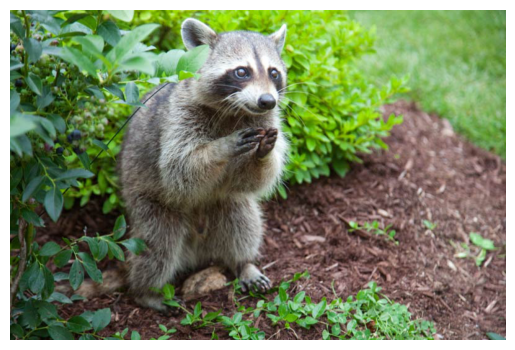

In [674]:
random_image = random.choice(image_names)
image_path = os.path.join(dir_path, random_image)
display_image(load_image(image_path))

#### Predict Bounding Boxes 

Image name: raccoon-74.jpg
Ground truth [[141 6 472 505]] (xmin, ymin, xmax, ymax)
Detected racoon.
Predicted bounding box [[21 113 477 439]] (ymin, xmin, ymax, xmax)


C:\Users\49176\AppData\Local\Temp\ipykernel_15192\2497522207.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_data = existing_data.append(new_data, ignore_index=True)


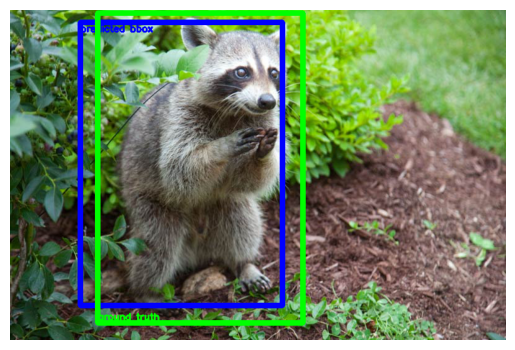

In [676]:
images = [image_path]
models = [pre_trained_detector]
predict(images, models)
#blue bounding boxes are generated by the model and green bounding boxes are the ground truth 
#from the csv file